In [335]:
### SIADS 696 : MILESTONE PROJECT 2 - DDOS DETECTION UNSUPERVISED LEARNING
### MANISH JAKHI

In [336]:
## INITIALIZATIONS

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from time import time
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import BisectingKMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import silhouette_score
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches
from sklearn.cluster import DBSCAN
import seaborn as sns


In [ ]:
# rear csv files into a df
df_ddos = pd.read_csv ('CSVs/ddos_traffic_model_ready.csv')
# print(df_ddos)

df_normal = pd.read_csv ('CSVs/normal_traffic_model_ready.csv')
# print(df_normal)

In [ ]:
# concatenating df_ddos and df_normal along rows
df_comb = pd.concat([df_ddos, df_normal], axis=0)
df_comb = df_comb.sample(frac = 1)


In [ ]:
## Numerical Mapping for categories
print(df_comb['CATEGORY'].value_counts())

CATEGORY_MAP0 = {'Slow HTTP GET': 1, 'Slow Read': 1, 'Slow Post':1, 'GoldenEye':1, 'Hulk':1,'Benign Traffic': 0}
df_comb['CATEGORY0'] = df_comb['CATEGORY'].map(CATEGORY_MAP0)


df_comb['CATEGORY1'] = df_comb['CATEGORY'].map(CATEGORY_MAP1)
CATEGORY_MAP1 = {'Slow HTTP GET':1, 'Slow Read':2, 'Slow Post':3, 'GoldenEye':4, 'Hulk':5, 'Benign Traffic':0}


CATEGORY_MAP2 = {'Slow HTTP GET': 'Malignant', 'Slow Read': 'Malignant', 
                 'Slow Post':'Malignant', 'GoldenEye':'Malignant', 'Hulk':'Malignant',
                 'Benign Traffic': 'Normal'}
df_comb['CATEGORY2'] = df_comb['CATEGORY'].map(CATEGORY_MAP2)


In [ ]:
# print(df_comb.head(10))
print(df_comb.columns)

In [ ]:
X = df_comb.drop(labels=['Address-A', 'Port-A', 'Address-B', 'Port-B', 'StreamID',
                         'PerctageFiltered', 'CATEGORY', 'Relative_Start',
                         'TotalPackets', 'Syn', 'Acknowledgment', 'Fin', 'Reset',
                         'Length', 'TCP Segment Len', 'Push', 'CATEGORY2',
                         'Duration', 'Header Length','Packets', 'Bytes', 'Bytes In Flight',
                         'Bits/s A-to-B (TX_bits/s)', 'Bits/s B-to-A (RX_bits/s)',
                         'Pktrate', 'Flow Duration','Pktrate nsec', 'Byte nsec',
                        'CATEGORY1', 'CATEGORY0'], axis=1)
print(X.columns)

In [ ]:
y = df_comb['CATEGORY0']
print(y.value_counts())

y_og = df_comb['CATEGORY1']
print(y_og.value_counts())

In [ ]:
print(f"# labels: {np.unique(y).size}; # samples: {X.shape[0]}; # features {X.columns.size}")

In [ ]:
def benchmark(model, name, data, labels):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    model : model instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    t0 = time()
    estimator = make_pipeline(StandardScaler(), model).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_]

    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.precision_score,
        metrics.recall_score,
        metrics.f1_score,
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # Show the results
    formatter_result = (
        "{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    )
    print(formatter_result.format(*results))

    # y_pred = estimator[-1].labels_
    # print(classification_report(y, y_pred, target_names=list(CATEGORY_MAP2.keys())))
    # print(results)

In [ ]:
print(82 * "_")
print("init\t\ttime\tinertia\tPrecision\tRecall\tF1\tHomo\tcompl\tv-meas\tARI\tAMI")

kmeans = KMeans(init="random", n_clusters=2, n_init=4, random_state=0)
benchmark(model=kmeans, name="random", data=X, labels=y)

kmeans = MiniBatchKMeans(n_clusters=2, n_init="auto", random_state=0,batch_size=6, max_iter=500)
benchmark(model=kmeans, name="MiniBatch", data=X, labels=y)

kmeans = BisectingKMeans(init="k-means++", n_clusters=2, random_state=0, max_iter=500, algorithm="elkan",
                        bisecting_strategy="largest_cluster")
benchmark(model=kmeans, name="BisectingKMeans", data=X, labels=y)

pca = PCA(n_components=2).fit(X)
kmeans = KMeans(init=pca.components_, n_clusters=2, n_init=1)
benchmark(model=kmeans, name="PCA-based", data=X, labels=y)

print(82 * "_")

In [ ]:
## PCA Analysis 

scale = StandardScaler()

X = scale.fit_transform(X)

X_DDOS_normalized = normalize(X)


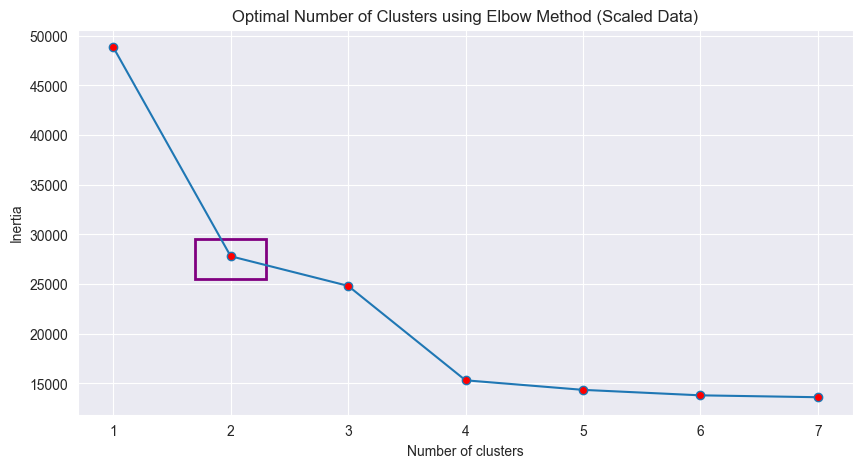

In [347]:
# Optimal Number of clusters evaluation - Elbow method

sse = []
k_list = range(1, 8)
for k in k_list:
    km = BisectingKMeans(init="k-means++", n_clusters=k, random_state=0, max_iter=500, algorithm="elkan",
                        bisecting_strategy="largest_cluster")
#     km = KMeans(n_clusters=k, n_init="auto")
    km.fit(X_DDOS_normalized)
    sse.append([k, km.inertia_])
    
results = pd.DataFrame({'Cluster': range(1,8), 'SSE': sse})
plt.figure(figsize=(10,5))
plt.plot(pd.DataFrame(sse)[0], pd.DataFrame(sse)[1], marker='o', mfc='red')
plt.title('Optimal Number of Clusters using Elbow Method (Scaled Data)')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
left, bottom, width, height = (1.7, 25500, 0.6, 4000)
rect=mpatches.Rectangle((left,bottom),width,height, fill=False,color="purple",linewidth=2)
plt.gca().add_patch(rect)

To determine the optimal number of clusters, we have to select the value of k at the “elbow” ie the point after which the distortion/inertia start decreasing in a linear fashion. It seem 2 or 4 clusters would be best and for the sake of simplicity we’ll select 2. 

The silhouette score is a metric used to evaluate the quality of clustering results. It takes into account both the cohesion of data points within a cluster and the separation between clusters. The silhouette score ranges from -1 to 1, where:

- A score of 1 indicates that clusters are well separated and distinct from each other, with cohesive and tightly packed data points within each cluster.
- A score of 0 indicates that clusters are overlapping or that the distance between them is not significant.
- A score of -1 indicates that clusters are poorly separated, with many data points misclassified or assigned to the wrong cluster.

In general, a higher silhouette score indicates better clustering results, with well-defined and well-separated clusters. However, the ideal score may vary depending on the specific context and data set being analyzed. It is important to use other evaluation metrics and domain knowledge to interpret and validate clustering results.

In [348]:
## Determing the silhouette score with number of clusters = 2

kmeans = BisectingKMeans(init="k-means++", n_clusters=2, random_state=0, max_iter=500, algorithm="elkan",
                        bisecting_strategy="largest_cluster").fit(X_DDOS_normalized)

print('KMeans Silhouette Score: {}'.format(silhouette_score(X_DDOS_normalized, kmeans.labels_, metric='euclidean')))

KMeans Silhouette Score: 0.4739346260763386


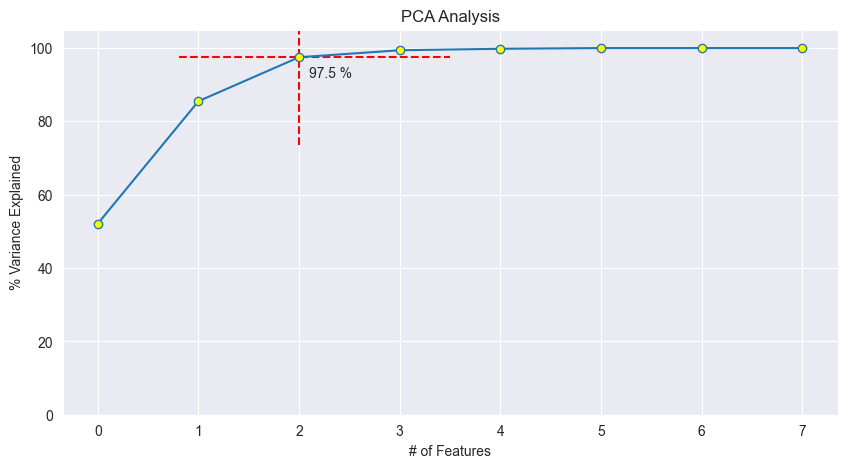

In [349]:
## Determining number if optimal principal components needed.

# n_components=8 because we have 8 features in the dataset

pca = PCA(n_components=8)
pca.fit(X_DDOS_normalized)
variance = pca.explained_variance_ratio_
var = np.cumsum(np.round(variance, 3)*100)

plt.figure(figsize=(10,5))
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis')
plt.axvline(x = 2, color = 'r', ymin = 0.7, linestyle = 'dashed')
plt.axhline(y = 97.5, color = 'r', xmin = 0.15, xmax = 0.5, linestyle = 'dashed')
plt.text(2.1,92,"97.5 %")

plt.ylim(0,105)
plt.plot(var, marker='o', mfc='yellow')

By examining the amount of variance each principal component encompasses we can see that the first 2 principal components explain roughly 97.5% of the variance. 

In [350]:
# Recalculating the silhouette score by applying Kmeans on PCA

In [351]:
# Transforming Using PCA
pca = PCA(n_components = 2).fit(X_DDOS_normalized)
X_pca = pca.transform(X_DDOS_normalized)

print(X_DDOS_normalized.shape ,X_pca.shape)

(53769, 8) (53769, 2)


In [352]:
kmeans_pca = BisectingKMeans(init="k-means++", n_clusters=2, random_state=0, max_iter=500, algorithm="elkan",
                        bisecting_strategy="largest_cluster").fit(X_pca)

print('KMeans PCA Scaled Silhouette Score: {}'.format(silhouette_score(X_pca, 
                                                                       kmeans_pca.labels_, metric='euclidean')))

KMeans PCA Scaled Silhouette Score: 0.5336276398652198


Silhouette Score improved from 0.47 to 0.53 after applying dimentionality reduction through the Kmean

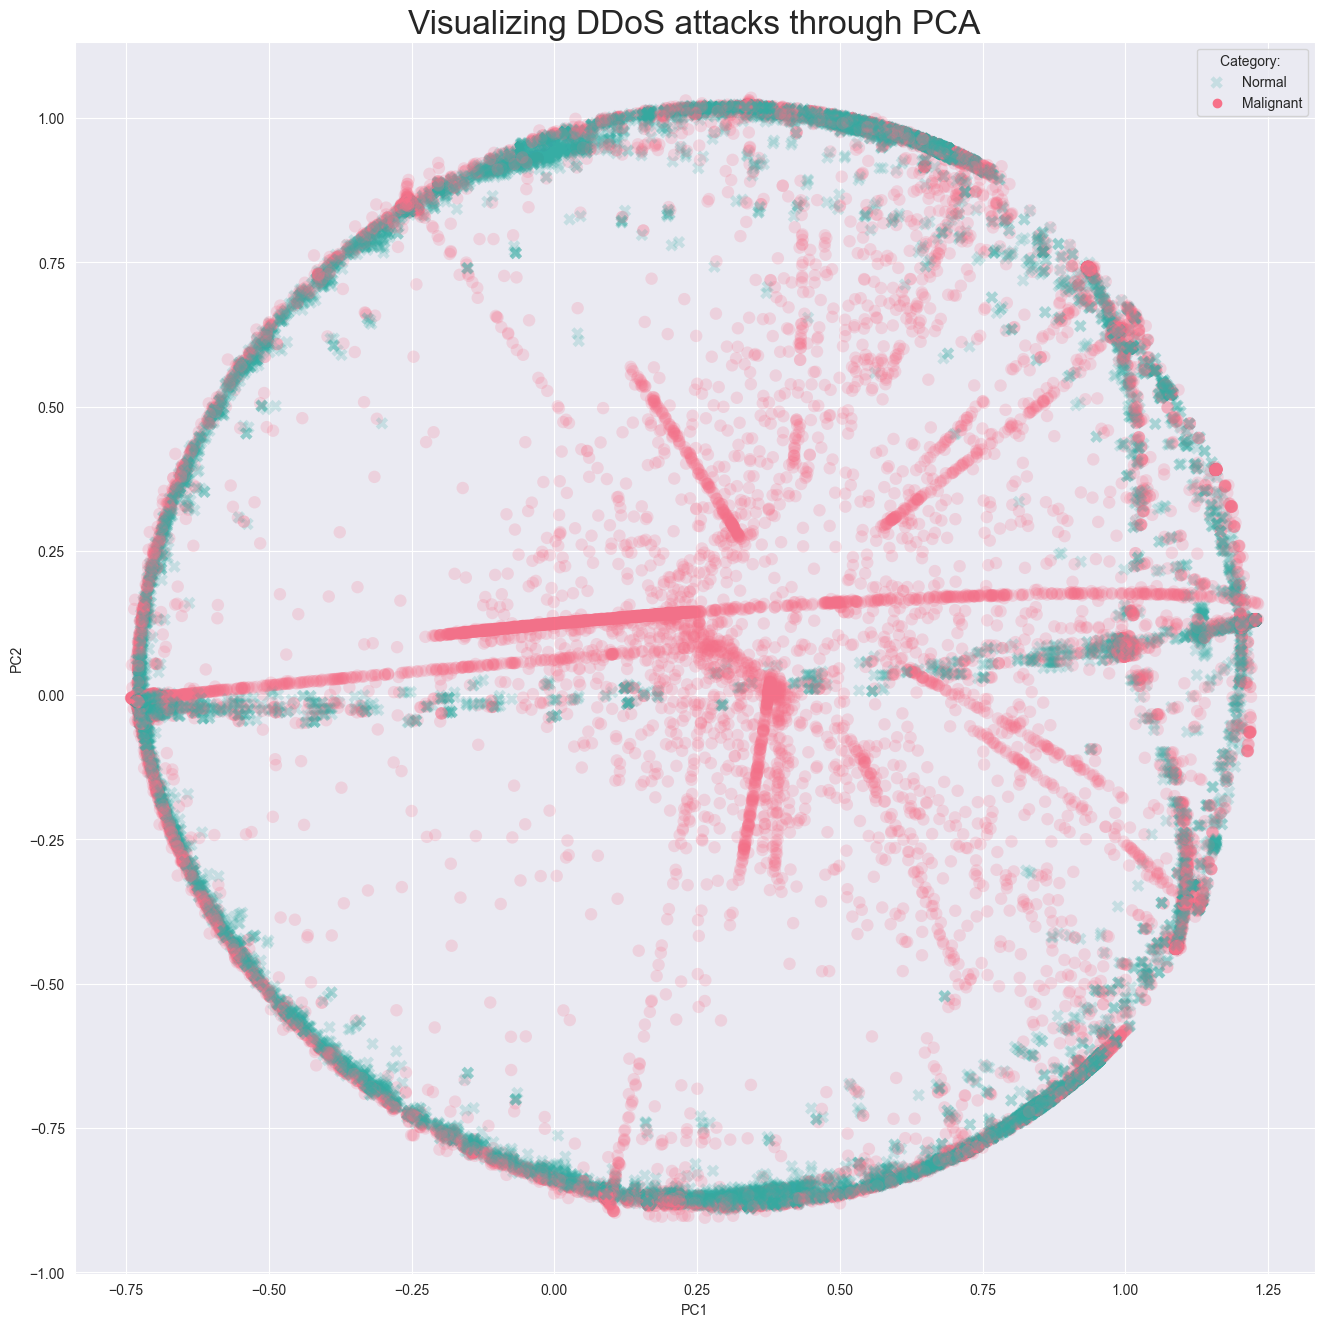

In [353]:
## PCA plot

plt.figure(figsize=(16,16))
g1 = sns.scatterplot(data = X_pca, x=X_pca[:, 0], y=X_pca[:, 1],hue=y, style = y, s=80, 
                     palette='husl', alpha = 0.20, edgecolor = 'none')
plt.title('Visualizing DDoS attacks through PCA', fontsize=24);
plt.legend(title='Category: ', loc='upper right', labels=['Normal', 'Malignant'])
plt.ylabel('PC2')
plt.xlabel('PC1')
plt.show(g1)

In [354]:
# Evaluating classification model with a confusion matrix 

conf_mat = confusion_matrix(y, kmeans_pca.labels_)
print(conf_mat)

[[12665  9647]
 [13768 17689]]


[Text(33.22222222222222, 0.5, 'True Label'),
 Text(0.5, 25.722222222222214, 'Predicted Label')]

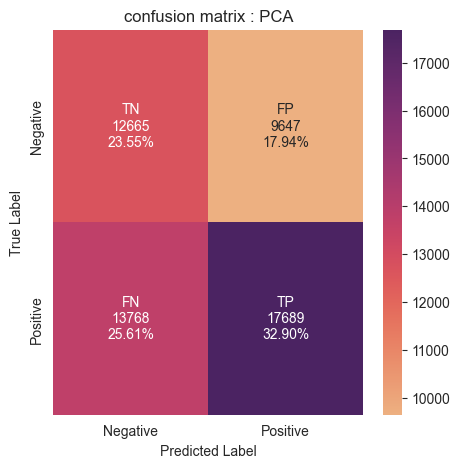

In [355]:
# plotting confusion matrix to define performance of the classification model

fig, ax = plt.subplots(figsize=(5,5)) 


group_names = ['TN','FP','FN', 'TP']
group_cnt = ["{0:0.0f}".format(value) for value in
                conf_mat.flatten()]
group_perc = ["{0:.2%}".format(value) for value in
                     conf_mat.flatten()/np.sum(conf_mat)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_cnt,group_perc)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(conf_mat, annot=labels, fmt='', cmap='flare')

label = ['Negative','Positive']
ax.set_title("confusion matrix : PCA")

ax.set_xticklabels(label)
ax.set_yticklabels(label)
ax.set(ylabel="True Label", xlabel="Predicted Label")

In [356]:
# Transforming Using t_SNE

# Defining and Fitting Model
X_tsne = TSNE(random_state = 42, n_components=2,verbose=0, perplexity=40, n_iter=600).fit_transform(X_DDOS_normalized)

print(X_DDOS_normalized.shape ,X_tsne.shape)

(53769, 8) (53769, 2)


In [357]:
kmeans_tsne = BisectingKMeans(init="k-means++", n_clusters=2, random_state=0, max_iter=500, algorithm="elkan",
                        bisecting_strategy="largest_cluster").fit(X_tsne)

print('KMeans T-SNE Scaled Silhouette Score: {}'.format(silhouette_score(X_tsne, 
                                                                         kmeans_tsne.labels_, metric='euclidean')))

KMeans T-SNE Scaled Silhouette Score: 0.3328518271446228


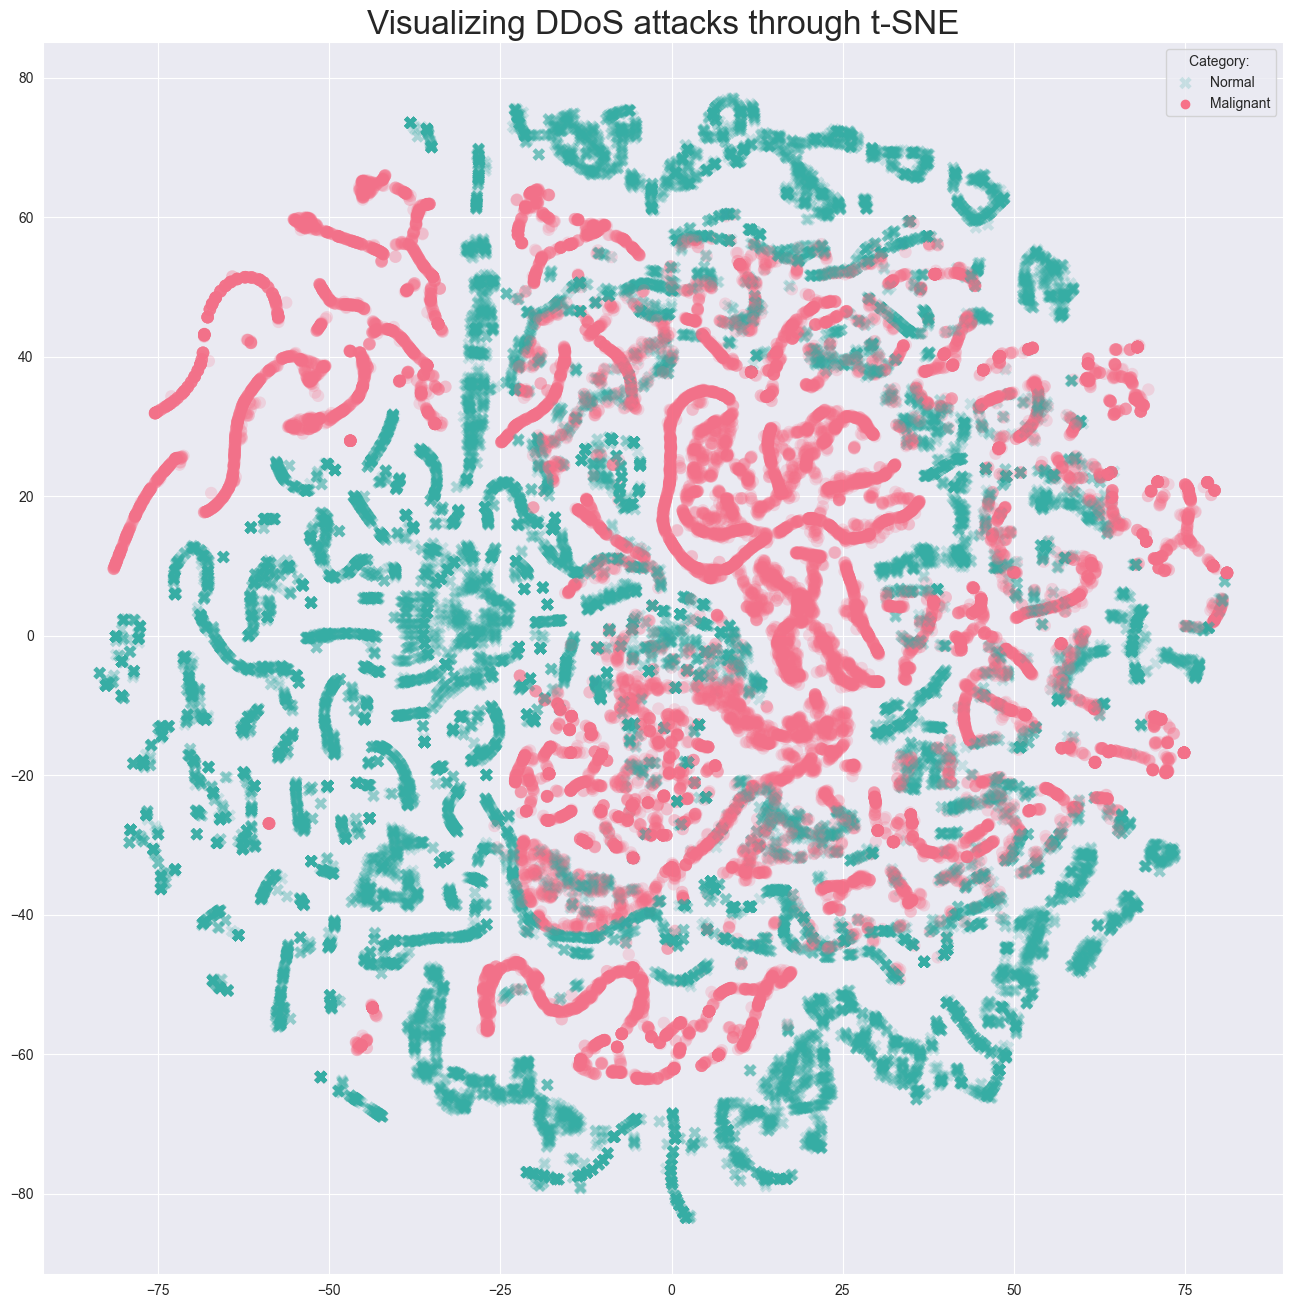

In [361]:
## T-SNE analysis

plt.figure(figsize=(16,16))

# Plotting 2d t-Sne
g1 = sns.scatterplot(data = X_tsne, x =X_tsne[:, 0], y =X_tsne[:, 1], hue=y, s=80, style = y,
                     palette='husl', alpha = 0.20, edgecolor = 'none')
plt.title('Visualizing DDoS attacks through t-SNE', fontsize=24);

plt.legend(title='Category: ', loc='upper right', labels=['Normal', 'Malignant'])

plt.show(g1)

In [359]:
# Evaluating classification model with a confusion matrix 

conf_mat = confusion_matrix(y, kmeans_tsne.labels_)
print(conf_mat)

[[13301  9011]
 [13724 17733]]


[Text(33.22222222222222, 0.5, 'True Label'),
 Text(0.5, 25.722222222222214, 'Predicted Label')]

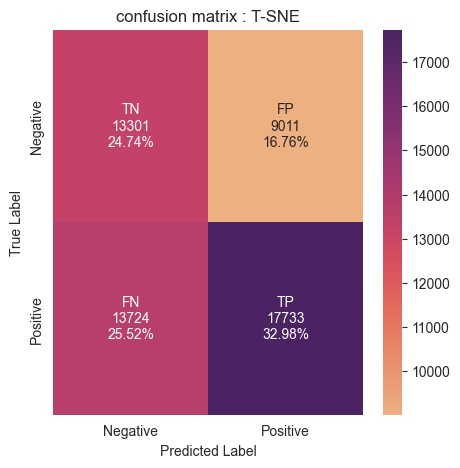

In [360]:
# plotting confusion matrix to define performance of the classification model

fig, ax = plt.subplots(figsize=(5,5)) 


group_names = ['TN','FP','FN', 'TP']
group_cnt = ["{0:0.0f}".format(value) for value in
                conf_mat.flatten()]
group_perc = ["{0:.2%}".format(value) for value in
                     conf_mat.flatten()/np.sum(conf_mat)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_cnt,group_perc)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(conf_mat, annot=labels, fmt='', cmap='flare')

label = ['Negative','Positive']
ax.set_title("confusion matrix : T-SNE")
ax.set_xticklabels(label)
ax.set_yticklabels(label)
ax.set(ylabel="True Label", xlabel="Predicted Label")